In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from matplotlib import pyplot as plt
import selfies as sf
import mutations as mut
from functools import partial
import metrics as met
import functions as fn
from constants import *
from rdkit import Chem
from rdkit.Chem import Draw
import seaborn as sns
import pandas as pd
from datetime import datetime
import time
from tqdm import tqdm
from guacamol import standard_benchmarks
import numpy as np
import random
from copy import copy
import crossovers as xo
import seaborn as sns
import matplotlib.pyplot as plt
import os

c:\Users\marti\anaconda3\envs\thesis_3.8\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
SEED_SIZE_LIST = [10, 100, 1000, 10000, 100000]
SEED_SIZE = SEED_SIZE_LIST[2]
SEED_LIST = [0,1,2]
SEED = SEED_LIST[2]
BUDGET_LIST = [100, 1000, 10000, 100000]
BUDGET = BUDGET_LIST[2]
GENERATIONS = 50




SAVE = True

In [4]:
celecoxib = 'O=S(=O)(c3ccc(n1nc(cc1c2ccc(cc2)C)C(F)(F)F)cc3)N'
troglitazone = 'O=C1NC(=O)SC1Cc4ccc(OCC3(Oc2c(c(c(O)c(c2CC3)C)C)C)C)cc4'
task_f = [partial(met.compound_similarity,target_smile = celecoxib),
         partial(met.compound_similarity,target_smile = troglitazone),
         partial(standard_benchmarks.median_camphor_menthol().objective.score_list),
         partial(standard_benchmarks.median_tadalafil_sildenafil().objective.score_list),
         partial(standard_benchmarks.hard_osimertinib().objective.score_list),
         partial(standard_benchmarks.zaleplon_with_other_formula().objective.score_list)]
task_names = ['celecoxib','troglitazone','med1','med2','osimertinib','zaleplon']




# Single metric optimization

In [5]:
#f = standard_benchmarks.zaleplon_with_other_formula().objective.score_list()

metric_function_list = [
    #partial(standard_benchmarks.zaleplon_with_other_formula().objective.score_list)
    #partial(standard_benchmarks.median_tadalafil_sildenafil().objective.score_list)
    partial(met.compound_similarity,target_smile = troglitazone)
]
metrics = ['Metric 1']

In [6]:
mutation_function_list = [
    partial(mut.replacement,n=1 ,ring_aware= False)
    ,partial(mut.addition,fragment_size=1,rings=False, branches=False)
    ,partial(mut.deletion,n=1)
]

In [7]:
for task_i in range(len(task_names[:2])):
    task_i+=4
    curr_task_f = task_f[task_i]
    curr_task_name = task_names[task_i]
    metric_function_list = [curr_task_f]

    current_dateTime = datetime.now()
    time_format = f"{current_dateTime.date()}_{str(current_dateTime.hour).zfill(2)}-{str(current_dateTime.minute).zfill(2)}-{str(current_dateTime.second).zfill(2)}"
    chem_lookup = {}

    try:
        pbar.close()
        print("Ignore the previous status bar. It is from the previous run.")
    except:
        pass


    for SEED in SEED_LIST:#SEED_LIST[1:]:
        for SEED_SIZE in SEED_SIZE_LIST[1:]:#[SEED_SIZE_LIST[1]]:#
            #SEED_PATH = f"../data/seed_{SEED}/rand_{SEED_SIZE}.tsv"
            #seed_df = pd.read_table(SEED_PATH) 
            #initial_pop, _, chem_lookup = fn.seeds_to_pop(seed_df,metric_function_list)
            INITIAL_PATH = f"{curr_task_name}_{SEED}_{SEED_SIZE}.csv"
            initial_pop = pd.read_csv(INITIAL_PATH)
            chem_lookup = fn.dataframe_to_dict(initial_pop)

            #chem_lookup.update(initial_pop.set_index('SMILES molecule')['Metric 1'].to_dict()) #canon and set
            for BUDGET in [BUDGET_LIST[-1]]:#BUDGET_LIST[:4]:#BUDGET_LIST[:4]#
                setup_name = f"seed_{SEED}_rand_{SEED_SIZE}"
                file_name = f"{time_format}_{setup_name}_budget_{BUDGET}"
                B0 = copy(BUDGET)
                generation = 0
                t0 = time.time()
                
                first_generation_fraction = 0.05 #hyperparam
                N = int(BUDGET * first_generation_fraction) #1st generation size

                if len(initial_pop)>=N:
                    initial_best = initial_pop.head(N)
                else:
                    initial_best = initial_pop
                gen_history = pd.DataFrame(initial_pop)
                gen_best_history = pd.DataFrame(initial_best)
                temp_best = initial_best.copy(deep=True)
                cost_history = []

                #rest of hyperparams
                crossover = True
                crossover_ratio = 0.2

                decreasing_size = True #if True, (leftover) BUDGET * next_generation_fraction = new N, else B0 * nfg = N
                next_generation_fraction = 0.05 #size of next generation

                minimal_next_generation_fraction = 0.0025
                max_gens = 500

                canonical_best = False
                percent_best_fraction = 0.1

                include_initial_pop = False
                initial_sample_fraction = 0.5 #initial_sample_size = len(temp_best) *  initial_sample_fraction ))

                diversity_decay = True
                selection_exponenet = 1


                pbar = tqdm(desc=f"Working with budget of {B0}",
                            total=B0)
                while (BUDGET > len(temp_best)):
                    diversity = fn.get_last_diversity(temp_best)
                    homogenity = 1 - diversity
                    temp_pop, cost, chem_lookup = fn.populate_from_df(temp_best,N,metric_function_list,mutation_function_list,
                                                generation+1,include_seeds=True,fitness='Fitness',crossover=crossover, crossover_type=0,
                                                crossover_ratio=crossover_ratio, proportional_sampling = True, 
                                                lookup_dict=copy(chem_lookup), randomize_seeds=True,
                                                avg_dist=diversity_decay,
                                                exp=selection_exponenet)
                    cost_history.append(cost)
                    BUDGET -= cost
                    temp_pop.reset_index(drop=True,inplace=True)
                    gen_history = pd.concat([gen_history,temp_pop])
                    gen_history.reset_index(drop=True,inplace=True)

                    if canonical_best:
                        temp_best = fn.get_canonical_percent_best(temp_pop,['Fitness'],percent_best_fraction,minimize=False)
                    else:
                        temp_best = fn.get_percent_best(temp_pop,['Fitness'],percent_best_fraction,minimize=False)    
                    gen_best_history = pd.concat([gen_best_history,temp_best])
                    gen_best_history.reset_index(drop=True,inplace=True)
                    
                    
                    
                    if include_initial_pop:
                        initial_sample_size = int(np.ceil(  len(temp_best) *  initial_sample_fraction   ))
                        temp_best = pd.concat([temp_best, initial_pop.sample(initial_sample_size)])
                    
                    if decreasing_size:
                        N = int(np.ceil(BUDGET * next_generation_fraction))
                    else:
                        N = int(np.ceil(B0 * next_generation_fraction))
                    if N<=int(np.ceil(minimal_next_generation_fraction*B0)):
                        N =int(np.ceil(minimal_next_generation_fraction*B0))
                    pbar.update(cost)
                    generation += 1

                    if generation>=max_gens:
                        break
                pbar.update(BUDGET)
                pbar.close()



                Z = 8
                #Z0 = 
                """
                crossover = True
                crossover_ratio = 0.2

                decreasing_size = True #if True, (leftover) BUDGET * next_generation_fraction = new N, else B0 * nfg = N
                next_generation_fraction = 0.05 #size of next generation

                minimal_next_generation_fraction = 0.0025
                max_gens = 500

                canonical_best = False
                percent_best_fraction = 0.1

                include_initial_pop = False
                initial_sample_fraction = 0.5 #initial_sample_size = len(temp_best) *  initial_sample_fraction ))

                diversity_decay = True
                selection_exponenet = 1
                """
                # Z1 = 
                # same as Z0, but with selection_exponenet ==2
                # Z2 =
                # same as Z0, but with canonical best == True
                # Z3 = 
                # same as Z2, but with include_initial_pop == True
                # Z4 =
                # same as Z3, but with initial_sample_fraction == 2.0
                # Z5 =
                # same as Z0
                # Z6
                # same as Z0, but with diversity_decay == False
                # Z7
                # same as Z6
                # Z8
                # same as Z0   




                print(f"Done {generation} in {time.time()-t0}")
                FOLDER_P = f"best_{curr_task_name}"
                if SAVE:
                    if not os.path.exists(FOLDER_P):
                        os.makedirs(FOLDER_P)
                    gen_best_history.to_csv(f"{FOLDER_P}/{file_name}.csv")
                FOLDER_P = f"all_{curr_task_name}"
                if SAVE:
                    if not os.path.exists(FOLDER_P):
                        os.makedirs(FOLDER_P)
                    gen_history.to_csv(f"{FOLDER_P}/{file_name}.csv")

    ###
    latest_gen = gen_best_history[gen_best_history['Generation']==gen_best_history['Generation'].max()]
    latest_gen.head()

Working with budget of 100: 100%|██████████| 100/100 [00:01<00:00, 98.12it/s]


Done 61 in 1.0221340656280518


Working with budget of 1000: 100%|██████████| 1000/1000 [00:07<00:00, 140.76it/s]


Done 110 in 7.107378005981445


Working with budget of 10000: 100%|██████████| 10000/10000 [01:07<00:00, 147.69it/s]


Done 134 in 67.71525740623474


Working with budget of 100: 100%|██████████| 100/100 [00:01<00:00, 90.66it/s]


Done 64 in 1.118995189666748


Working with budget of 1000: 100%|██████████| 1000/1000 [00:07<00:00, 132.62it/s]


Done 110 in 7.543509483337402


Working with budget of 10000: 100%|██████████| 10000/10000 [01:11<00:00, 139.58it/s]


Done 128 in 71.64888715744019


Working with budget of 100: 100%|██████████| 100/100 [00:01<00:00, 91.32it/s]


Done 64 in 1.1130008697509766


Working with budget of 1000: 100%|██████████| 1000/1000 [00:07<00:00, 128.70it/s]


Done 121 in 7.772293329238892


Working with budget of 10000: 100%|██████████| 10000/10000 [01:15<00:00, 133.23it/s]


Done 139 in 75.06183290481567


Working with budget of 100: 100%|██████████| 100/100 [00:02<00:00, 40.85it/s]


Done 63 in 2.4820008277893066


Working with budget of 1000: 100%|██████████| 1000/1000 [00:10<00:00, 96.40it/s]


Done 123 in 10.38394570350647


Working with budget of 10000: 100%|██████████| 10000/10000 [01:17<00:00, 128.62it/s]


Done 129 in 77.75744318962097


Working with budget of 100: 100%|██████████| 100/100 [00:01<00:00, 70.00it/s]


Done 64 in 1.6005113124847412


Working with budget of 1000: 100%|██████████| 1000/1000 [00:07<00:00, 131.14it/s]


Done 115 in 7.627680063247681


Working with budget of 10000: 100%|██████████| 10000/10000 [01:14<00:00, 133.42it/s]


Done 148 in 74.95697093009949


Working with budget of 100: 100%|██████████| 100/100 [00:01<00:00, 74.13it/s]


Done 63 in 1.365001916885376


Working with budget of 1000: 100%|██████████| 1000/1000 [00:07<00:00, 133.73it/s]


Done 115 in 7.479999780654907


Working with budget of 10000: 100%|██████████| 10000/10000 [01:15<00:00, 131.64it/s]


Done 155 in 75.9695885181427


Working with budget of 100: 100%|██████████| 100/100 [00:01<00:00, 68.59it/s]


Done 63 in 1.4785165786743164


Working with budget of 1000: 100%|██████████| 1000/1000 [00:07<00:00, 130.92it/s]


Done 111 in 7.641467332839966


Working with budget of 10000: 100%|██████████| 10000/10000 [01:17<00:00, 128.63it/s]


Done 149 in 77.74300122261047


Working with budget of 100: 100%|██████████| 100/100 [00:02<00:00, 37.06it/s]


Done 64 in 2.73087215423584


Working with budget of 1000: 100%|██████████| 1000/1000 [00:10<00:00, 97.48it/s]


Done 120 in 10.269547462463379


Working with budget of 10000: 100%|██████████| 10000/10000 [01:20<00:00, 124.40it/s]


Done 150 in 80.39773273468018


Working with budget of 100: 100%|██████████| 100/100 [00:01<00:00, 64.57it/s]


Done 64 in 1.7268357276916504


Working with budget of 1000: 100%|██████████| 1000/1000 [00:07<00:00, 125.76it/s]


Done 108 in 7.954448699951172


Working with budget of 10000: 100%|██████████| 10000/10000 [01:15<00:00, 132.27it/s]


Done 136 in 75.60540866851807


Working with budget of 100: 100%|██████████| 100/100 [00:01<00:00, 63.65it/s]


Done 62 in 1.5879995822906494


Working with budget of 1000: 100%|██████████| 1000/1000 [00:08<00:00, 123.39it/s]


Done 116 in 8.10606598854065


Working with budget of 10000: 100%|██████████| 10000/10000 [01:15<00:00, 132.97it/s]


Done 150 in 75.21162295341492


Working with budget of 100: 100%|██████████| 100/100 [00:01<00:00, 59.31it/s]


Done 63 in 1.7031989097595215


Working with budget of 1000: 100%|██████████| 1000/1000 [00:08<00:00, 121.89it/s]


Done 114 in 8.207031488418579


Working with budget of 10000: 100%|██████████| 10000/10000 [01:17<00:00, 128.98it/s]


Done 132 in 77.53821158409119


Working with budget of 100: 100%|██████████| 100/100 [00:03<00:00, 32.59it/s]


Done 67 in 3.099999189376831


Working with budget of 1000: 100%|██████████| 1000/1000 [00:10<00:00, 95.05it/s]


Done 111 in 10.53211259841919


Working with budget of 10000: 100%|██████████| 10000/10000 [01:21<00:00, 121.98it/s]


Done 137 in 81.9926905632019


In [8]:
float(latest_gen.head()['Metric 1'].max())

0.7110681947099659

In [9]:
print(len(chem_lookup))

288141


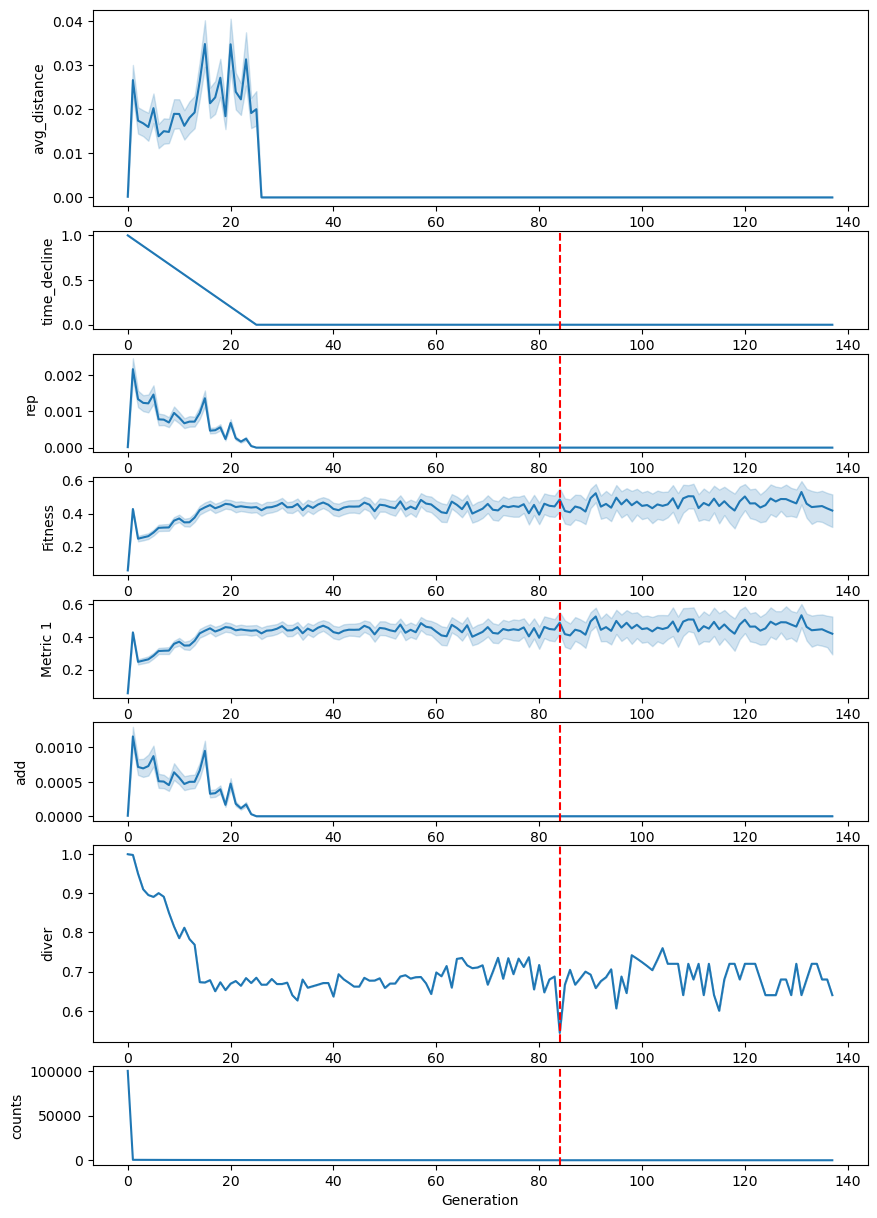

In [10]:
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import pandas as pd

try:
    fig = plt.figure(figsize=(10, 15))
    gs = gridspec.GridSpec(8, 1, height_ratios=[2, 1, 1, 1, 1, 1, 2, 1])  # Adjust as needed

    # List of y-values for line plots
    y_values = ['avg_distance', 'time_decline', 'rep', 'Fitness', 'Metric 1', 'add']

    # Create subplots using the grid
    axes = [plt.subplot(gs[i]) for i in range(8)]

    # Create line plots
    for ax, y in zip(axes, y_values):
        sns.lineplot(data=gen_history, x='Generation', y=y, ax=ax)

    # Additional calculations and plots
    gen_history['diver'] = gen_history.groupby('Generation')['Canonical SMILES'].transform(lambda x: (len(pd.unique(x))-1)/len(x))
    sns.lineplot(data=gen_history, x='Generation', y='diver', ax=axes[6])

    count_data = gen_history.groupby('Generation').size().reset_index(name='counts')
    sns.lineplot(data=count_data, x='Generation', y='counts', ax=axes[7])

    # Get the generation with the lowest diversity after generation 0
    # find the row with the minimum diversity after generation 0
    min_diversity_row = gen_history[gen_history['Generation']>0].nsmallest(1, 'diver')

    # get the generation of that row
    lowest_diver = min_diversity_row['Generation'].values[0]
    #lowest_diver = gen_history[gen_history['diver']<0.2]['Generation'].min()
    # add a vertical dashed line at the generation where diversity is the lowest after generation 0
    #ax2.axvline(lowest_diver, linestyle='--', color='red')


    # Add a vertical dashed line at the first generation where diversity is the lowest after generation 0
    for ax in axes[1:]:
        ax.axvline(lowest_diver, linestyle='--', color='red')

    # Show the plot
    plt.show()

except:
    pass




Meidan score


[]

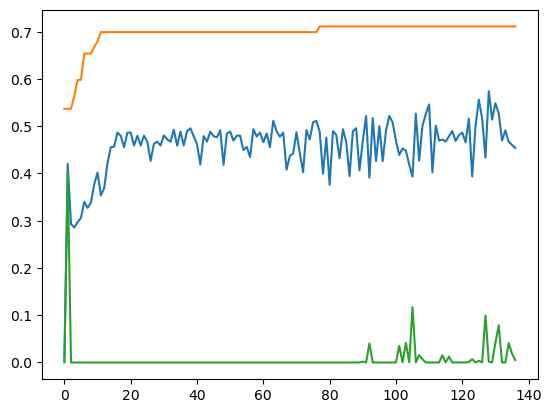

In [11]:
data = [(np.median(gen_history[gen_history['Generation']==i]['Metric 1'])) for i in range(0,np.max(gen_history['Generation']))]
sns.lineplot(data)
data = [(np.max(gen_history[gen_history['Generation']==i]['Metric 1'])) for i in range(0,np.max(gen_history['Generation']))]
sns.lineplot(data)
data = [(np.min(gen_history[gen_history['Generation']==i]['Metric 1'])) for i in range(0,np.max(gen_history['Generation']))]
sns.lineplot(data)
plt.plot()

Diversity

<Axes: >

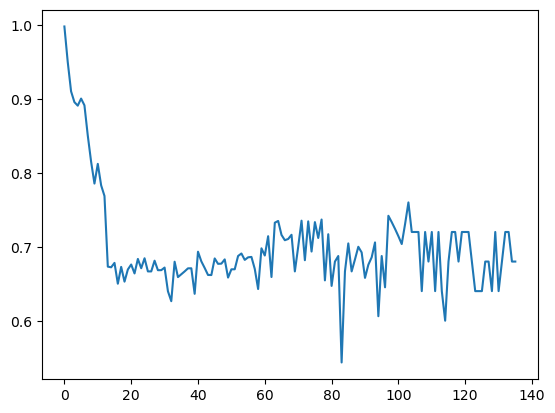

In [12]:
data = [(len(pd.unique(gen_history[gen_history['Generation']==i]['SMILES'].apply(lambda x: fn.canonicalize_smile(x))))-1)/len((gen_history[gen_history['Generation']==i]['SMILES'])) for i in range(1,gen_history['Generation'].max())]
sns.lineplot(data)

# BEST size

<Axes: >

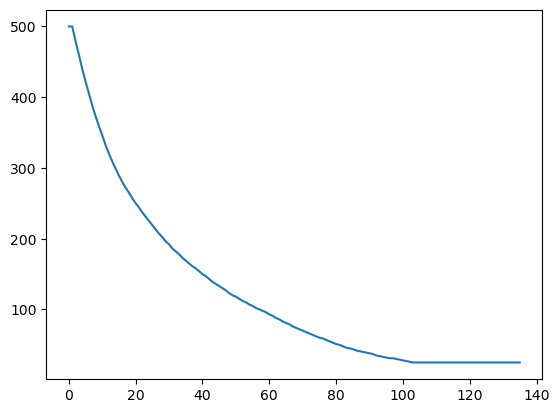

In [13]:
dayta = [len((gen_history[gen_history['Generation']==i]['SMILES'])) for i in range(1,gen_history['Generation'].max())]
sns.lineplot(dayta)

<Axes: >

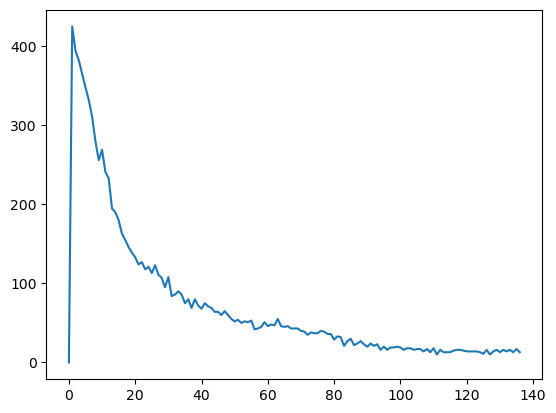

In [14]:
sns.lineplot(cost_history)

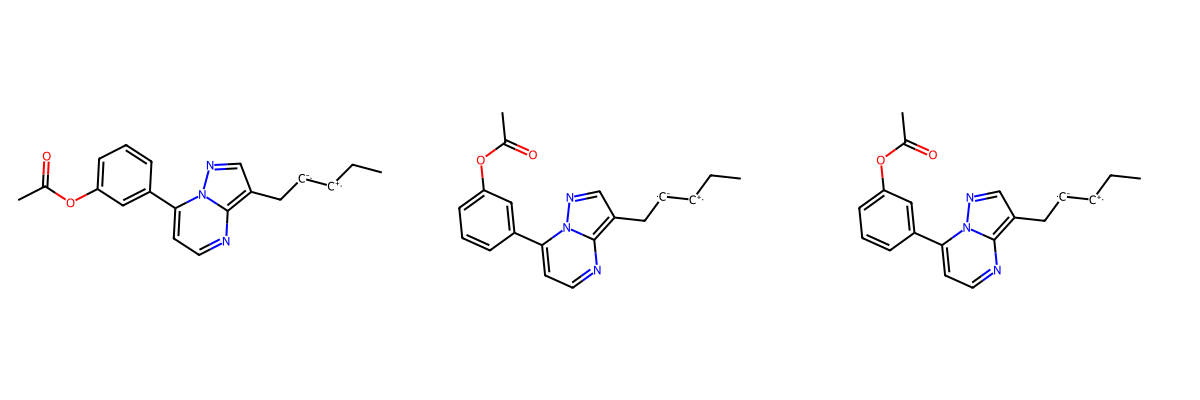

In [15]:
latest_gen_mol = [Chem.MolFromSmiles(molecule) for molecule in set(latest_gen["SMILES"][:6])]
img = Draw.MolsToGridImage(latest_gen_mol, 
                           molsPerRow=3,
                           subImgSize=(400, 400), 
                           maxMols=len(latest_gen),
                           legends=None)
display(img)

In [16]:
plot_metric_generations = False
if plot_metric_generations:
    import pandas as pd
    import numpy as np
    import seaborn as sns
    import matplotlib.pyplot as plt
    from scipy.stats import norm


    generations = gen_history['Generation'].unique()
    generations.sort()  # Make sure generations are sorted

    pal = sns.cubehelix_palette(len(generations), rot=-.25, light=.7)

    # Initialize a FacetGrid object
    g = sns.FacetGrid(gen_history, row="Generation", hue="Generation", aspect=15, height=.5, palette=pal)

    # Draw the densities in a few steps
    g.map(sns.kdeplot, "Metric 1", clip_on=False, shade=True, alpha=1, lw=1.5, bw_method=.2)
    #g.map(sns.kdeplot, "Metric 1", clip_on=False, color="w", lw=2, bw_method=.2)
    g.map(plt.axhline, y=0, lw=2, clip_on=False)

    # Define and use a simple function to label the plot in axes coordinates
    def label(x, color, label):
        ax = plt.gca()
        ax.text(0, .2, label, fontweight="bold", color=color,
                ha="left", va="center", transform=ax.transAxes)

    g.map(label, "Metric 1")

    # Set the subplots to overlap
    g.fig.subplots_adjust(hspace=-.0)

    # Remove axes details that don't play well with overlap
    g.set_titles("")
    g.set(yticks=[], ylabel="")
    g.despine(bottom=True, left=True)
    plt.xlabel('Zaleplon similarity ', fontsize=14)
    plt.ylabel('Generation', fontsize=14)

    plt.show()


,Unnamed: 0.1,Unnamed: 0,SMILES,SELFIES,Canonical SMILES,Canonical SELFIES,Split canonical SELFIES,Generation,Metric 1,avg_distance,time_decline,time_increase,rep,atr,add,Fitness
0,0,0,C1C=CC=C(C=1)N1C(C2C=CC=CC=2)=C(C(C)=N1)C,[C][C][=C][C][=C][Branch1][Ring2][C][=Ring1][=...,Cc1nn(-c2ccccc2)c(-c2ccccc2)c1C,[C][C][=N][N][Branch1][=Branch2][C][=C][C][=C]...,"['[C]', '[C]', '[=N]', '[N]', '[Branch1]', '[=...",0,0.658982,0.059561,1.0,-25,0.003548,0,0.002338,0.661319
1,1,1,C1=C(C=CC(=C1)C1=CC(C#CCN(O)C(=O)CC)=NN1C1C=CC...,[C][=C][Branch2][Ring2][O][C][=C][C][=Branch1]...,CCC(=O)N(O)CC#Cc1cc(-c2ccc(C)cc2)n(-c2ccc(OC)c...,[C][C][C][=Branch1][C][=O][N][Branch1][C][O][C...,"['[C]', '[C]', '[C]', '[=Branch1]', '[C]', '[=...",0,0.656836,0.065526,1.0,-25,0.004294,0,0.002829,0.659666
2,2,2,O1CCN(CC1)C1C=CC=C(OCC2=NN(C3C=CC(S(=O)(C)=O)=...,[O][C][C][N][Branch1][Branch1][C][C][Ring1][=B...,CS(=O)(=O)c1ccc(-n2nc(COc3cccc(N4CCOCC4)c3)cc2...,[C][S][=Branch1][C][=O][=Branch1][C][=O][C][=C...,"['[C]', '[S]', '[=Branch1]', '[C]', '[=O]', '[...",0,0.645402,0.077044,1.0,-25,0.005936,0,0.003912,0.649313
3,3,3,C(=O)(N(O)C(C)C#CC1C=C(C2C=CC(CC)=CC=2)N(N=1)C...,[C][=Branch1][C][=O][Branch2][Ring2][=C][N][Br...,CCc1ccc(-c2cc(C#CC(C)N(O)C(C)=O)nn2-c2ccc(OC)c...,[C][C][C][=C][C][=C][Branch2][Ring2][Branch1][...,"['[C]', '[C]', '[C]', '[=C]', '[C]', '[=C]', '...",0,0.633162,0.066021,1.0,-25,0.004359,0,0.002872,0.636034
4,4,4,C(CO[N+](=O)[O-])CC(=O)C1C=C(C2=CC=C(S(=O)(C)=...,[C][Branch1][Branch2][C][O][N+1][=Branch1][C][...,CS(=O)(=O)c1ccc(-c2cc(C(=O)CCCO[N+](=O)[O-])nn...,[C][S][=Branch1][C][=O][=Branch1][C][=O][C][=C...,"['[C]', '[S]', '[=Branch1]', '[C]', '[=O]', '[...",0,0.630542,0.071520,1.0,-25,0.005115,0,0.003371,0.633913
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
99991,99991,99991,NOC,[N][O][C],CON,[C][O][N],"['[C]', '[O]', '[N]']",0,0.002191,0.000000,1.0,-25,0.000000,0,0.000000,0.002191
99992,99992,99992,SC(C)C,[S][C][Branch1][C][C][C],CC(C)S,[C][C][Branch1][C][C][S],"['[C]', '[C]', '[Branch1]', '[C]', '[C]', '[S]']",0,0.002181,0.000000,1.0,-25,0.000000,0,0.000000,0.002181
99993,99993,99993,CCSCC,[C][C][S][C][C],CCSCC,[C][C][S][C][C],"['[C]', '[C]', '[S]', '[C]', '[C]']",0,0.002176,0.000000,1.0,-25,0.000000,0,0.000000,0.002176
99994,99994,99994,[Br-],[Br-1],[Br-],[Br-1],['[Br-1]'],0,0.000000,0.000000,1.0,-25,0.000000,0,0.000000,0.000000
